In [1]:
import torch
import numpy as np

In [2]:
cd '/home/animesh/Desktop/Research Project/MANNSuite/Matrix-NTM'

/home/animesh/Desktop/Research Project/MANNSuite/Matrix-NTM


In [3]:
MNTM = torch.load('/home/animesh/Desktop/Research Project/MANNSuite/Matrix-NTM/SavedModels/MatNTM_FillCopy_Cuda1/INP6_6_HID30_30_MD120_6_6_Adam4CE_RepCopy100000/MNTM.pth')

In [4]:
import matplotlib.pyplot as plt

In [26]:




def OneBatchSequence(seq_size = [4,5], item_size = 2, num_items = 15, query_num = 14, sample_range = [0.1,0.9]):
    
    #assert num_items > query_num
    
    limiter = torch.zeros([seq_size[0]+1, seq_size[1]])
    limiter[-1,0] = 1.0
    limiter[-1,-1] = 1.0
    
    
    cat_list = []
    for i in range(num_items):
        
        cat_list.append(limiter)
        
        content = torch.rand([seq_size[0]+1, seq_size[1] * item_size])
        content[:-1,:][content[:-1,:] > 0.5] = 1.0
        content[-1,:] = 0.0
        content[content != 1] = 0.0
        cat_list.append(content)
        
    
    delimeter = torch.zeros([seq_size[0]+1, seq_size[1]])
    delimeter[-1,1:-1] = 1.0
    cat_list.append(delimeter)
    
    
    start = seq_size[1]*query_num + (query_num - 1)*(seq_size[1]*(item_size))
    stop = seq_size[1]*query_num + (query_num - 1)*(seq_size[1]*(item_size)) + (seq_size[1]*(item_size)) 
    
    sequence = torch.cat(cat_list, dim = 1)
    

    
    #Colouring sof delimiters
    colours = torch.tensor(np.random.permutation(np.linspace(sample_range[0],sample_range[1],num=num_items+1)))
    #print(colours)
    for i in range(1,1+int(sequence.shape[1]/seq_size[1]),item_size+1):
        #print(i//(item_size+1))
        sequence[-1,i*5 - 5] *= colours[i//(item_size+1)]
        sequence[-1,i*5 - 1] *= colours[i//(item_size+1)]
            
    
    query = sequence[:,start-seq_size[1]:stop - seq_size[1]*(item_size) ]
    expected_result = sequence[:,start  : stop   ] * float(query[-1,0])

    
    
    finalsequence = torch.cat([sequence, query], dim = 1)
    
    
    
    return finalsequence, expected_result




def GenRandBatchSeq(batch_size=32, seq_size = [4,5], item_size = 2, num_items = 15, device = None):
    
    seq_list = []
    res_list = []
    
    
    
    for i in range(batch_size):
        query_num = torch.randint(low=1, high=num_items+1, size=[])
        seq, res = OneBatchSequence(seq_size=seq_size, item_size=item_size, num_items=num_items, query_num=query_num)
        seq_list.append(seq.unsqueeze(0))
        res_list.append(res.unsqueeze(0))
    
    seq_tensor = torch.cat(seq_list, dim=0)
    res_tensor = torch.cat(res_list, dim=0)
    
    return seq_tensor.to(device), res_tensor.to(device)


In [27]:


def Bit_Seq_Error(output , target, batch_size=16):
    bit_output = output.detach().clone()
    bit_output[bit_output >= 0.5] = 1.0
    bit_output[bit_output != 1.0] = 0.0
    bit_error = torch.sum((torch.abs(target - bit_output)) )/batch_size
    return bit_error

loss_func = torch.nn.BCELoss()




In [32]:
num_items = torch.randint(low=2, high=16, size=[])
item_size = 3#int(torch.randint(low=2, high=4, size=[]))

inp, out = GenRandBatchSeq(batch_size=16, seq_size=[4,5], item_size=item_size, num_items=num_items, device='cuda:0')
#inp, out = MatrixCopyDataGen(32,[4,5],num_t)

response_sheet = torch.zeros_like(out)


print("--->Number of Items: ",int(num_items))

MNTM.HiddenReset()

MNTM.zero_grad()



#Feeding the sequence
#Input sequence is of length inp.shape[2]/5 

num_sequences = int(inp.shape[2]/5)


for t in range(1,num_sequences+1):
    _ = MNTM(inp[:,:,(t-1)*5:t*5])
                               #5 is the seq_size[1]                    

#del inp
#Taking Output from controller now, for backprop
output = []
                # 2 is the item_size
for t in range(1,item_size+1):
    MNTM_out = MNTM(response_sheet[:,:,(t-1)*5:t*5])
    output.append(MNTM_out)

#del response_sheet
res = torch.cat(output, dim=2)

loss = loss_func(res, out)

bit_seq_error = Bit_Seq_Error(res, out, batch_size=16)

print("----->Loss: {}".format(loss))

--->Number of Items:  10
----->Loss: 1.0157493352890015


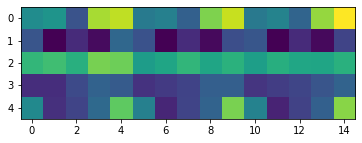

In [29]:
plt.imshow(res[0].detach().cpu())

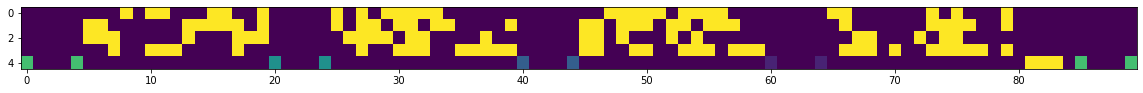

In [30]:
plt.figure(figsize=(20,12))
plt.imshow(inp[0].cpu())

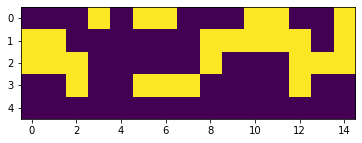

In [31]:
plt.imshow(out[0].cpu())

In [19]:
out[0]

tensor([[-0.0000, -0.0818, -0.0818, -0.0000, -0.0818, -0.0000, -0.0000, -0.0818,
         -0.0000, -0.0000, -0.0818, -0.0000, -0.0000, -0.0818, -0.0000],
        [-0.0818, -0.0818, -0.0000, -0.0000, -0.0818, -0.0000, -0.0818, -0.0000,
         -0.0818, -0.0000, -0.0818, -0.0818, -0.0000, -0.0818, -0.0000],
        [-0.0000, -0.0818, -0.0818, -0.0000, -0.0000, -0.0818, -0.0818, -0.0818,
         -0.0000, -0.0818, -0.0000, -0.0818, -0.0000, -0.0818, -0.0000],
        [-0.0818, -0.0000, -0.0818, -0.0000, -0.0818, -0.0818, -0.0818, -0.0818,
         -0.0818, -0.0000, -0.0818, -0.0818, -0.0818, -0.0000, -0.0000],
        [-0.0000, -0.0000, -0.0000, -0.0000, -0.0000, -0.0000, -0.0000, -0.0000,
         -0.0000, -0.0000, -0.0000, -0.0000, -0.0000, -0.0000, -0.0000]],
       device='cuda:0')

In [20]:
def CELoss(output, target):
    return -torch.mean(target*torch.log(output) + (1-target)*torch.log(1-output))

In [21]:
CELoss(res.detach().cpu(), out.detach().cpu())

tensor(-0.0045)